<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Introduction" data-toc-modified-id="Introduction-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Introduction</a></span></li><li><span><a href="#Data" data-toc-modified-id="Data-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Data</a></span></li><li><span><a href="#Perform-variance-component-selection" data-toc-modified-id="Perform-variance-component-selection-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Perform variance component selection</a></span><ul class="toc-item"><li><span><a href="#Installation" data-toc-modified-id="Installation-3.1"><span class="toc-item-num">3.1&nbsp;&nbsp;</span>Installation</a></span></li><li><span><a href="#vcselect-function" data-toc-modified-id="vcselect-function-3.2"><span class="toc-item-num">3.2&nbsp;&nbsp;</span><code>vcselect</code> function</a></span></li><li><span><a href="#Estimation-without-penalty" data-toc-modified-id="Estimation-without-penalty-3.3"><span class="toc-item-num">3.3&nbsp;&nbsp;</span>Estimation without penalty</a></span></li><li><span><a href="#Selection-at-specific-tuning-parameter" data-toc-modified-id="Selection-at-specific-tuning-parameter-3.4"><span class="toc-item-num">3.4&nbsp;&nbsp;</span>Selection at specific tuning parameter</a></span></li><li><span><a href="#Solution-path" data-toc-modified-id="Solution-path-3.5"><span class="toc-item-num">3.5&nbsp;&nbsp;</span>Solution path</a></span></li><li><span><a href="#Plot-solution-path" data-toc-modified-id="Plot-solution-path-3.6"><span class="toc-item-num">3.6&nbsp;&nbsp;</span>Plot solution path</a></span></li></ul></li></ul></div>

## Introduction

This tutorial goes over how to select relevant variance components for genetic main effects and gene-treatment interaction effects using [`VarianceComponentSelect.jl`](https://github.com/juhkim111/VarianceComponentSelect.jl).

In [1]:
versioninfo()

Julia Version 1.1.1
Commit 55e36cc (2019-05-16 04:10 UTC)
Platform Info:
  OS: macOS (x86_64-apple-darwin15.6.0)
  CPU: Intel(R) Core(TM) i5-6267U CPU @ 2.90GHz
  WORD_SIZE: 64
  LIBM: libopenlibm
  LLVM: libLLVM-6.0.1 (ORCJIT, skylake)


## Data

Suppose we have following variables:

* `y`: $324 \times 1$ response vector (phenotype of interest for 324 individuals)
* `y2`: another $324 \times 1$ response vector
* `X`: $324 \times 1$ covariate (sex) matrix 
* `G`: $150 \times 1$ vector whose $i$-th element is a $324 \times q_i$ genotype matrice (matrix of minor allele counts) for gene $i$, where $i=1,\ldots, 150$ and $q_i$ is the number of variants for gene $i$
* `trtvec`: $324 \times 1$ vector indicating treatment status. 

These variables are saved in `.jld2` file, which was briefly discussed in the previous tutorial [`tutorial_SNPset`](./tutorial_SNPset.ipynb#Load-genotype-data-from-.RData). This file is not available due to large size. 

For information about reading in genotype data, gene annotation data, pheontype data, etc. saved in different format (`.bed`, `.RData`, `.txt`), refer to the previous tutorial [`tutorial_SNPset`](./tutorial_SNPset.ipynb#Load-genotype-data-from-.RData). 

First, read in variables using `JLD2` package.

In [1]:
using JLD2
@load "/Users/juhyun-kim/Box Sync/workspace/vcselect/codebase/julia/VarianceComponentSelect.jl/docs/SNPset_interaction.jld2" m y y2 X G V trtvec

7-element Array{Symbol,1}:
 :m     
 :y     
 :y2    
 :X     
 :G     
 :V     
 :trtvec

`m` indicates the number of genes.

In [3]:
m

150

Our phenotype vector `y` and `y2`:

In [4]:
y

324-element Array{Float64,1}:
 -0.40911273847444835 
 -0.0597995644528963  
  0.02798994878695149 
 -0.5810287222548617  
  0.4325440331155418  
  0.048256153207898195
 -0.27027696763685594 
  0.10490944338119751 
 -0.7799009563553139  
 -0.20593444247247622 
  0.5520065403740653  
 -0.10092686337307819 
  0.5983104367265357  
  ⋮                   
  0.03739468023738035 
  0.47352506877371714 
 -0.22836115042409924 
 -0.3876214190551975  
  0.10326243849550518 
 -0.4882830145406528  
 -0.06903684417417116 
  0.09798041795966334 
 -0.1480073641765541  
 -0.29900800903355274 
 -0.008878790322644575
 -0.09571535379121696 

In [5]:
y2

324-element Array{Float64,1}:
 1.3258185642149818 
 1.8085252404396581 
 1.708986006453134  
 0.6998067885683363 
 1.4124188772264397 
 0.6498171962040651 
 1.902080374302     
 1.0645731494585338 
 1.6881140939960915 
 0.5968115428908066 
 1.834394340252028  
 0.5430782512369362 
 0.7995903398352917 
 ⋮                  
 1.1189761372892286 
 0.15748437463812337
 1.8181028615482917 
 1.9883522612534137 
 1.5285148555773462 
 0.6670856329923743 
 0.5457786311896112 
 2.2390247532510625 
 0.7981911508204723 
 0.9269595573820882 
 1.0460748428040245 
 1.7881016354346437 

Covariate matrix indicating sex: 

In [6]:
X

324-element Array{Float64,1}:
 1.0
 2.0
 2.0
 1.0
 2.0
 1.0
 2.0
 2.0
 2.0
 1.0
 2.0
 1.0
 1.0
 ⋮  
 1.0
 1.0
 2.0
 2.0
 2.0
 1.0
 1.0
 2.0
 1.0
 1.0
 1.0
 2.0

Vector of gentoype matrix for each gene: 

In [7]:
G

150-element Array{Array{Float64,2},1}:
 [2.0 0.0 … 2.0 2.0; 2.0 1.0 … 1.4486 2.0; … ; 2.0 0.0 … 1.0 2.0; 2.0 0.0 … 2.0 2.0] 
 [2.0 2.0 … 2.0 2.0; 2.0 1.0 … 1.0 0.0; … ; 2.0 1.0 … 1.0 0.0; 2.0 2.0 … 1.0 2.0]    
 [2.0 2.0 … 0.0 2.0; 2.0 2.0 … 2.0 2.0; … ; 2.0 2.0 … 1.0 2.0; 2.0 2.0 … 0.0 1.0]    
 [2.0 1.0 … 0.0 2.0; 2.0 1.0 … 0.0 2.0; … ; 2.0 0.0 … 1.0 2.0; 1.0 1.0 … 1.0 2.0]    
 [1.0 2.0 … 0.0 2.0; 1.0 2.0 … 1.0 2.0; … ; 0.0 2.0 … 1.0 2.0; 2.0 2.0 … 0.0 2.0]    
 [2.0 2.0 … 1.0 2.0; 2.0 2.0 … 1.0 2.0; … ; 2.0 2.0 … 1.0 2.0; 2.0 2.0 … 1.0 2.0]    
 [2.0 1.0 … 1.0 2.0; 2.0 1.0 … 1.0 2.0; … ; 2.0 2.0 … 0.0 2.0; 2.0 2.0 … 1.0 2.0]    
 [1.0 1.0 … 1.0 1.0; 1.0 2.0 … 1.0 0.0; … ; 2.0 2.0 … 2.0 1.0; 2.0 2.0 … 2.0 1.0]    
 [2.0 2.0 … 2.0 0.0; 2.0 1.0 … 1.0 0.0; … ; 1.0 2.0 … 2.0 0.0; 2.0 2.0 … 2.0 1.0]    
 [2.0 2.0 … 2.0 1.0; 2.0 2.0 … 2.0 1.0; … ; 2.0 2.0 … 2.0 1.0; 2.0 0.0 … 2.0 1.0]    
 [1.0 2.0 … 2.0 2.0; 0.0 1.0 … 2.0 2.0; … ; 2.0 1.0 … 2.0 2.0; 1.0 0.0 … 1.0 2.0]    
 [2.0 0.0 … 2.0

Elements in `G` are matrices of size $324\times q_i$. Number of rows must be the same (n=324) because each row is for each individual. On the other hand, number of columns vary because number of SNPs/variants vary among genes. Here we list different sizes elements of `G` have: 

In [8]:
unique(size.(G))

8-element Array{Tuple{Int64,Int64},1}:
 (324, 44)
 (324, 27)
 (324, 47)
 (324, 14)
 (324, 42)
 (324, 29)
 (324, 30)
 (324, 18)

## Perform variance component selection 

We assume that response vector $y$ is distributed as 

$$y \sim \text{Normal}(X\beta, \sigma_{11}^2 V_{11} + \sigma_{12}^2 V_{12} + \cdots + \sigma_{150, 1}^2 V_{150, 1} + \sigma_{150, 2}^2 V_{150, 2} + \sigma_0^2  I_n),$$

where $\sigma_{i1}$ and $\sigma_{i2}$ are $i$-th gene's variance components for genetic main effect and interaction effect between gene and treatment, respectively. Let $T = \text{diag}(t_1, \ldots, t_n)$ be a matrix of $\{0,1\}$ that indicates treatment status, then covariance matrices associated with $\sigma_{i1}$ and $\sigma_{i2}$ are 

<a id='V_i'></a>
\begin{eqnarray}
V_{i1} &=& G_iG_i^T  \\
V_{i2} &=& TG_iG_i^TT^T.
\end{eqnarray}





We wish to jointly select genetic main effect and gene-treatment interaction effect associated with response $y$. In other words, we want to either include or exclude main effect and interaction effect together.


This selection can be done using `VarianceComponentSelect` package in Julia. 

### Installation

First, add `VarianceComponentSelect.jl` package first. 

The package `VarianceComponentSelect.jl` has not yet been registered and must be installed using the repository location. Start julia and use the `]` key to switch to the package manager REPL

First load the package.

In [3]:
using VarianceComponentSelect

┌ Info: Recompiling stale cache file /Users/juhyun-kim/.julia/compiled/v1.1/VarianceComponentSelect/iiLmX.ji for VarianceComponentSelect [684d1ed6-5d62-11e9-0c0b-878d753c12b1]
└ @ Base loading.jl:1184


### `vcselect` function

Variance components estimation/selection is achieved via `vcselect` function in `VarianceComponentSelect.jl` package. 

<a id='vcselect'></a>
**`vcselect` function:**  

Required arguments of `vcselect` are (in following order):

* `y`, response vector
* `X`, design matrix (if exists)
* `G`, vector of genotype matrices, i.e. $(G_1, \ldots, G_m)$, where $m$ is no. of genes
* `trt`, vector or diagonal matrix of treatment status.

Keyword arguments are:

* `penfun`, penalty function (e.g. `NoPenalty()`, `L1Penalty()`), default is `NoPenalty()`
* `λ`, tuning parameter value, default is 1.0
* `penwt`, penalty weight, default is (1,1,...1,0)   
    - `penwt` is a $(m+1) \times 1$ vector
* `σ2`, initial estimates for main effects, default is (1,...,1)
    - `σ2` is a $(m+1) \times 1$ vector where $m$ is no. of genes
    - $i$-th element ($i=1,\ldots, m$) of the vector indicates main effect for $i$-th gene while the last element ($i=m+1$ or `σ2[end]`) is residual variance
* `σ2int`, initial estimates for interaction effects, default is (1,...,1) 
    - `σ2int` is a $m \times 1$ vector where $m$ is no. of genes, $i$-th element of the vector indicates interaction effect for $i$-th gene 
* `maxiter`, maximum number of iterations, default is 1000
* `tol`, convergence tolerance, default is `1e-6`
* `standardize`, logical flag for covariance matrix standardization, default is `true`
    - if true, [$V_i, \forall i$](#V_i) is standardized by its Frobenius norm
* `verbose`, display switch, default is `false`. 

*Note:*
   1. keyword argument in Julia should be called with its label. For example, if we wish to specify `λ` value, call
  `vcselect(y, G, trt; λ=1.2)`
   2. characters such as `λ` and `σ` can be entered via tab completion of LaTeX-like abbreviations. For example, type `\lambda` and press tab (see [Julia documentation](https://pkg.julialang.org/docs/julia/THl1k/1.1.1/manual/unicode-input.html) for more information)

Output we get from `vcselect`: 

* `σ̂2`: estimates of variance components for genetic main effects 
* `σ̂2int`: estimates of variance components for interaction effects 
* `β̂`: estimates of fixed effects parameter vector
* `obj`: objective value at `σ̂2` and `σ̂2int`
* `niters`: the number of iterations to convergence.


Example:

### Estimation without penalty

First, we estimate $\sigma^2 = (\sigma_{1,1}^2, \ldots, \sigma_{150, 1}^2, \sigma_0^2)$ and $\sigma_{\text{int}}^2 = (\sigma_{1,2}^2, \ldots, \sigma_{150, 2}^2)$ using no penalty (equivalent to having tuning parameter $\lambda=0$). 

In [10]:
σ̂2, σ̂2int, obj, = vcselect(y, G, trtvec)

([2.47456e-133, 6.91631e-16, 2.74742e-131, 2.82996e-5, 2.81179e-29, 8.89749, 3.54969e-59, 5.44155e-64, 3.07073e-67, 5.22001e-20  …  2.19867e-59, 8.67764e-32, 4.21348e-39, 0.0195491, 1.99438e-99, 3.06776, 7.86276, 1.73261e-125, 23.6083, 1.0e-8], [2.09192e-76, 4.38297e-15, 2.41334e-82, 1.53249e-119, 2.8901e-25, 2.58535e-90, 3.60753e-53, 1.67914e-91, 8.19294, 5.10787e-94  …  1.38711e-26, 1.92824e-32, 1.87229e-36, 8.46851e-42, 5.89475e-145, 3.37843e-93, 4.57356e-67, 7.62438e-33, 1.40826e-98, 1.20963], -4.951724824677399, 1000, [0.59068 0.520779 … 0.543698 0.532752; 0.520779 0.560247 … 0.526809 0.51657; … ; 0.543698 0.526809 … 0.609993 0.540741; 0.532752 0.51657 … 0.540741 0.80964])

Let us look at the estimates of variance components for genetic main effects, `σ̂2`. Note that `σ̂2` is a vector of length 151. $i$-th element, $i=1,\ldots, 150$, in `σ̂2` represents $i$-th variance component for genetic effect; the last element represents the residual variance component. 

In [11]:
σ̂2

151-element Array{Float64,1}:
  2.4745632889805717e-133
  6.916307201058052e-16  
  2.7474189209269256e-131
  2.8299603145628244e-5  
  2.8117873973924636e-29 
  8.897486919785152      
  3.5496919493698e-59    
  5.441546220735568e-64  
  3.0707344922473554e-67 
  5.2200113237183096e-20 
  1.169810697674553e-113 
  5.705525909982981e-91  
  9.930208200052615e-153 
  ⋮                      
  7.567471630250054e-92  
  9.076946568164731e-20  
  2.1986721394936255e-59 
  8.677635217778256e-32  
  4.21348004805262e-39   
  0.019549134086801454   
  1.9943838946582884e-99 
  3.067758097386263      
  7.862763767698653      
  1.73260654711531e-125  
 23.608283601669488      
  1.0e-8                 

Now we look at variance components for interaction effects, `σ̂2int`. `σ̂2int` is a vector of length 150; $i$-th element represents interaction effect for $i$-th gene, $i=1,\ldots, 150$.  

In [12]:
σ̂2int

150-element Array{Float64,1}:
 2.0919194808510807e-76 
 4.382968922539042e-15  
 2.4133407404713058e-82 
 1.532488880784894e-119 
 2.890095811395827e-25  
 2.585347520288329e-90  
 3.6075293249935155e-53 
 1.6791440338081073e-91 
 8.192938478208921      
 5.107872507433504e-94  
 2.139174448261416e-114 
 5.7937394346658857e-67 
 1.2920802205174169e-151
 ⋮                      
 4.708041871139142e-40  
 1.172215603907712e-18  
 1.3871051007908335e-26 
 1.9282374191274542e-32 
 1.8722899525604334e-36 
 8.468513167689876e-42  
 5.8947506599162265e-145
 3.378432162758553e-93  
 4.573556724739435e-67  
 7.624379052023211e-33  
 1.4082620163378275e-98 
 1.2096313786872745     

We repeat the same steps but with different response vector `y2` and with covariate matrix `X`.

In [13]:
σ̂2, σ̂2int, β̂, obj, niters = vcselect(y2, X, G, trtvec)

([0.720942, 0.0139205, 3.15374e-32, 1.32196e-50, 0.756394, 2.5851e-35, 0.000123378, 5.34248e-14, 0.0411477, 1.8563e-10  …  8.05214e-9, 9.49897e-17, 5.39319e-50, 1.28776e-47, 5.04786e-16, 5.08369e-40, 1.55783e-5, 6.51537e-44, 2.98774, 1.0e-8], [9.56196e-25, 4.99491e-33, 5.8344e-26, 2.25154e-53, 1.69961e-44, 7.03312e-30, 6.22876e-20, 8.45028e-14, 2.69071e-31, 5.04986e-36  …  8.27399e-26, 4.17169e-31, 9.70123e-20, 4.79236e-67, 2.97268e-36, 1.97281e-16, 2.41001e-29, 7.57894, 2.73093e-33, 1.85777e-15], 1.0194980131616957, -24.660513448981362, 390, [0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0; … ; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0])

In [14]:
σ̂2

151-element Array{Float64,1}:
 0.720941611619576     
 0.013920517451115047  
 3.153736708830043e-32 
 1.3219572516490768e-50
 0.756393532455148     
 2.5850967778710774e-35
 0.00012337813079897516
 5.342481629109731e-14 
 0.041147657833245664  
 1.8562990135872406e-10
 1.4592584459959114e-33
 1.3591997219082403e-21
 2.1561957964345847e-14
 ⋮                     
 3.7581860899096285e-37
 8.484153875303747e-17 
 8.052135013431383e-9  
 9.498972301135848e-17 
 5.393188441894421e-50 
 1.2877636846858508e-47
 5.047860110377529e-16 
 5.083689142073733e-40 
 1.55783012430925e-5   
 6.515367453475338e-44 
 2.9877417460025306    
 1.0e-8                

In [15]:
σ̂2int

150-element Array{Float64,1}:
 9.561957719074461e-25 
 4.994906608786025e-33 
 5.834398525828848e-26 
 2.251544115850124e-53 
 1.6996111013868343e-44
 7.033121889331132e-30 
 6.228757662846687e-20 
 8.45028365638942e-14  
 2.6907112516535222e-31
 5.049857139325772e-36 
 6.973957692628832e-41 
 0.9838050715820016    
 5.2745540275386866e-42
 ⋮                     
 3.4573703534917033e-19
 4.0204906134908254e-26
 8.273988825681072e-26 
 4.171685494396821e-31 
 9.701231403880321e-20 
 4.7923593168359894e-67
 2.9726759599948798e-36
 1.9728079924734e-16   
 2.4100145445817165e-29
 7.57894129468278      
 2.730928997153293e-33 
 1.857773791242076e-15 

Fixed effects parameter estimate:

In [16]:
β̂

1.0194980131616957

### Selection at specific tuning parameter 

Here we estimate variance components with lasso penalty (`penfun=L1Penalty()`) at specific tuning parameter value, say `λ=1.5`. To do so, we utilize keyword arguments of `vcselect` function (refer to [previous section](#vcselect)). 

In [17]:
σ̂2, σ̂2int, obj, niters, = vcselect(y, G, trtvec; penfun=L1Penalty(), λ=1.5)

([0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0  …  0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 7.78637, 1.08929], [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0  …  0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.484863], 46.98620144829175, 142, [0.113706 0.0450203 … 0.0504186 0.0461796; 0.0450203 0.10445 … 0.0444487 0.0406221; … ; 0.0504186 0.0444487 … 0.114743 0.0464476; 0.0461796 0.0406221 … 0.0464476 0.148721])

In [18]:
σ̂2

151-element Array{Float64,1}:
 0.0               
 0.0               
 0.0               
 0.0               
 0.0               
 0.0               
 0.0               
 0.0               
 0.0               
 0.0               
 0.0               
 0.0               
 0.0               
 ⋮                 
 0.0               
 0.0               
 0.0               
 0.0               
 0.0               
 0.0               
 0.0               
 0.0               
 0.0               
 0.0               
 7.786365592930441 
 1.0892949378889574

Let us see which ones are selected (i.e. positive).

In [19]:
findall(x -> x > 0, σ̂2[1:end-1])

3-element Array{Int64,1}:
  69
  73
 150

Estimates for interaction effects variance components:

In [20]:
σ̂2int

150-element Array{Float64,1}:
 0.0               
 0.0               
 0.0               
 0.0               
 0.0               
 0.0               
 0.0               
 0.0               
 0.0               
 0.0               
 0.0               
 0.0               
 0.0               
 ⋮                 
 0.0               
 0.0               
 0.0               
 0.0               
 0.0               
 0.0               
 0.0               
 0.0               
 0.0               
 0.0               
 0.0               
 0.4848633840962044

Indices of positive variance components:

In [21]:
findall(x -> x > 0, σ̂2int[1:end])

3-element Array{Int64,1}:
  69
  73
 150

Repeat the same steps but we incorporate covariate matrix `X` and different tuning parameter value `λ=3.5`.

In [22]:
σ̂2, σ̂2int, β̂, obj, niters, = vcselect(y2, X, G, trtvec; penfun=L1Penalty(), λ=3.5)

([0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0  …  0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.38188e-12, 0.0, 1.34757, 0.935617], [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0  …  0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 3.86795, 0.0, 0.481598], 1.0319045713518604, 30.17317267087384, 128, [0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0; … ; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0])

`σ̂2` is a $151\times1$ vector. $i$-th value in `σ̂2` represents variance component for $i$-th gene, $i=1,\ldots,150$. The last value in `σ̂2` is estimated $\widehat{\sigma}_0^2.$

In [23]:
σ̂2

151-element Array{Float64,1}:
 0.0                  
 0.0                  
 0.0                  
 0.0                  
 0.0                  
 0.0                  
 0.0                  
 0.0                  
 0.0                  
 0.0                  
 0.0                  
 0.0                  
 0.0                  
 ⋮                    
 0.0                  
 0.0                  
 0.0                  
 0.0                  
 0.0                  
 0.0                  
 0.0                  
 0.0                  
 1.381882532524876e-12
 0.0                  
 1.347569476212896    
 0.9356166604584287   

In [24]:
findall(x -> x > 0, σ̂2[1:end-1])

5-element Array{Int64,1}:
  71
 112
 127
 148
 150

In [25]:
σ̂2int

150-element Array{Float64,1}:
 0.0               
 0.0               
 0.0               
 0.0               
 0.0               
 0.0               
 0.0               
 0.0               
 0.0               
 0.0               
 0.0               
 0.0               
 0.0               
 ⋮                 
 0.0               
 0.0               
 0.0               
 0.0               
 0.0               
 0.0               
 0.0               
 0.0               
 0.0               
 3.867947664140097 
 0.0               
 0.4815978752739884

In [26]:
findall(x -> x > 0, σ̂2int[1:end])

5-element Array{Int64,1}:
  71
 112
 127
 148
 150

Estimated fixed effects parameter:

In [27]:
β̂

1.0319045713518604

Number of iterations to convergence:

In [28]:
niters

128

Objective value at `σ̂2`:

In [29]:
obj

30.17317267087384

### Solution path 


What if we want to look at solutions across different tuning parameter values? Then we obtain a solution path. To that end, we use `vcselectpath` function in `VarianceComponentSelect` package. 

**`vcselectpath` function:**

Required arguments of `vcselect` are (in following order):

* `y`, response vector
* `X`, design matrix (if exists)
* `G`, vector of genotype matrices, i.e. $(G_1, \ldots, G_m)$, where $m$ is no. of genes
* `trt`, vector or diagonal matrix of treatment status.

Keyword arguments are:

* `penfun`, penalty function (e.g. `NoPenalty()`, `L1Penalty()`), default is `NoPenalty()`
* `penwt`, penalty weight, default is (1,1,...1,0)   
    - `penwt` is a $(m+1) \times 1$ vector
* `nλ`, the number of lambda values, default is 100
* `λpath`, a user supplied `λ` sequence. 
    - Typically the program computes its own `λ` sequence based on `nλ`; supplying `λpath` overrides this
* `σ2`, initial estimates for main effects, default is (1,...,1)
    - `σ2` is a $(m+1) \times 1$ vector where $m$ is no. of genes
    - $i$-th element ($i=1,\ldots, m$) of the vector indicates main effect for $i$-th gene while the last element ($i=m+1$ or `σ2[end]`) is residual variance
* `σ2int`, initial estimates for interaction effects, default is (1,...,1) 
    - `σ2int` is a $m \times 1$ vector where $m$ is no. of genes, $i$-th element of the vector indicates interaction effect for $i$-th gene 
* `maxiter`, maximum number of iterations, default is 1000
* `tol`, convergence tolerance, default is `1e-6`
* `standardize`, logical flag for covariance matrix standardization, default is `true`
    - if true, [$V_i, \forall i$](#V_i) is standardized by its Frobenius norm
    
Output: 

* `σ̂2path`, matrix of estimated variance components for genetic main effects 
* `σ̂2intpath`, matrix of estimated variance components for interaction effects 
* `β̂path`, matrix of fixed effects parameter estimates 
* `objpath`, vector of objective value at `σ̂2` and `σ̂2int`
* `λpath`, the actual sequence of `λ` values used
* `niterspath`, vector of the number of iterations to convergence.



We obtain solution path using lasso penalty (`penfun=L1Penalty()`). The program computes its own `λ` sequence since we do not supply one. 

In [4]:
σ̂2path, σ̂2intpath, β̂path, _, λpath, = vcselectpath(y2, X, G, trtvec; 
            penfun=L1Penalty())

([0.720942 0.822496 … 0.0 0.0; 0.0139205 0.0 … 0.0 0.0; … ; 2.98774 2.56417 … 0.0 0.0; 1.0e-8 1.0e-8 … 1.33275 1.3342], [9.56196e-25 7.47711e-41 … 0.0 0.0; 4.99491e-33 0.0 … 0.0 0.0; … ; 2.73093e-33 0.0 … 0.0 0.0; 1.85777e-15 1.05476e-22 … 0.0 0.0], [1.0195 1.02133 … 0.97101 0.970646], [-24.6605, 3.32904, 27.8883, 51.0684, 73.5878, 33.3611, 36.0908, 38.6682, 41.1134, 43.4405  …  109.486, 110.011, 110.533, 111.053, 111.569, 112.082, 112.592, 113.1, 113.604, 114.106], 0.0:0.9827301785834965:97.29028767976615, [390, 302, 150, 71, 16, 354, 7, 8, 7, 8  …  2, 2, 2, 2, 2, 2, 2, 2, 2, 2])

Let us inspect the solution path. 

$i$-th column in `σ̂2path` is variance components estimates at $i$-th $\lambda$ value in `λpath`. In the solution path, 151 rows and 100 columnns represent 151 variance components and 100 tuning parameter values, respectively. $i$-th row represents estimates of $\sigma_i^2$, $i=1,\ldots, 150$ while the last row represents estimates of $\sigma_0^2$. From left to right, $\lambda$ value is supposed to increase, which can be verified by displaying `λpath`.

In [4]:
σ̂2path

151×100 Array{Float64,2}:
 0.720942     0.822496     0.866081     …  0.0          0.0         
 0.0139205    0.0          0.0             0.0          0.0         
 3.15374e-32  0.0          0.0             0.0          0.0         
 1.32196e-50  0.0          0.0             0.0          0.0         
 0.756394     0.769584     0.833198        0.0          0.0         
 2.5851e-35   0.0          0.0          …  0.0          0.0         
 0.000123378  0.0          0.0             0.0          0.0         
 5.34248e-14  0.0          0.0             0.0          0.0         
 0.0411477    0.0          0.0             0.0          0.0         
 1.8563e-10   0.0          0.0             0.0          0.0         
 1.45926e-33  0.0          0.0          …  0.0          0.0         
 1.3592e-21   0.0          0.0             0.0          0.0         
 2.1562e-14   0.0          0.0             0.0          0.0         
 ⋮                                      ⋱                           
 3.75819

Note the `λpath` given below. It ranges from $0$ to $97.2902$ and it increments by $0.982.$
First column in `σ̂2path_lasso` contains estimates at $\lambda=0.0$, second column is at $\lambda=0.982$, and so on.

In [36]:
λpath

0.0:0.9827301785834965:97.29028767976615

We also print estimate for fixed effects parameter $\beta$ at each $\lambda.$ 

In [37]:
β̂path

1×100 Array{Float64,2}:
 1.0195  1.02133  1.0283  1.0263  1.02628  …  0.971374  0.97101  0.970646

Alternatively, you can supply your own grid of tuning parameter values. Say we want 100 $\lambda$ values to be linearly spaced from 0 to 3.5, i.e. `λpath=range(0, 3.5, length=100)`.

In [42]:
σ̂2path2, σ̂2intpath2, β̂path2, _, λpath2, = vcselectpath(y2, X, G, trtvec;
       penfun=L1Penalty(), λpath=range(0, 95.0, length=20))

([0.720942 0.82318 … 0.0 0.0; 0.0139205 0.0 … 0.0 0.0; … ; 2.98774 1.90941 … 0.0 0.0; 1.0e-8 2.96025e-6 … 1.32365 1.33076], [9.56196e-25 5.12364e-30 … 0.0 0.0; 4.99491e-33 0.0 … 0.0 0.0; … ; 2.73093e-33 0.0 … 0.0 0.0; 1.85777e-15 8.77148e-17 … 0.0 0.0], [1.0195 1.02978 … 0.973309 0.971461], [-24.6605, 95.4136, 46.0415, 55.8919, 60.6595, 65.6307, 70.2126, 74.4868, 78.5084, 82.3167, 85.9414, 89.4052, 92.7262, 95.9189, 98.9953, 101.965, 104.837, 107.619, 110.315, 112.932], 0.0:5.0:95.0, [390, 86, 106, 18, 56, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5])

Let's take a look at the solution path. 

In [43]:
σ̂2path2

151×20 Array{Float64,2}:
 0.720942     0.82318     1.92322e-227  …  0.0          0.0        
 0.0139205    0.0         0.0              0.0          0.0        
 3.15374e-32  0.0         0.0              0.0          0.0        
 1.32196e-50  0.0         0.0              0.0          0.0        
 0.756394     0.762276    0.0              0.0          0.0        
 2.5851e-35   0.0         0.0           …  0.0          0.0        
 0.000123378  0.0         0.0              0.0          0.0        
 5.34248e-14  0.0         0.0              0.0          0.0        
 0.0411477    0.0         0.0              0.0          0.0        
 1.8563e-10   0.0         0.0              0.0          0.0        
 1.45926e-33  0.0         0.0           …  0.0          0.0        
 1.3592e-21   0.0         0.0              0.0          0.0        
 2.1562e-14   0.0         0.0              0.0          0.0        
 ⋮                                      ⋱                          
 3.75819e-37  0.0      

In [46]:
σ̂2intpath2

150×20 Array{Float64,2}:
 9.56196e-25  5.12364e-30  4.25645e-263  …  0.0       0.0       0.0     
 4.99491e-33  0.0          0.0              0.0       0.0       0.0     
 5.8344e-26   0.0          0.0              0.0       0.0       0.0     
 2.25154e-53  0.0          0.0              0.0       0.0       0.0     
 1.69961e-44  6.72981e-58  0.0              0.0       0.0       0.0     
 7.03312e-30  0.0          0.0           …  0.0       0.0       0.0     
 6.22876e-20  0.0          0.0              0.0       0.0       0.0     
 8.45028e-14  0.0          0.0              0.0       0.0       0.0     
 2.69071e-31  0.0          0.0              0.0       0.0       0.0     
 5.04986e-36  0.0          0.0              0.0       0.0       0.0     
 6.97396e-41  0.0          0.0           …  0.0       0.0       0.0     
 0.983805     0.0          0.0              0.0       0.0       0.0     
 5.27455e-42  0.0          0.0              0.0       0.0       0.0     
 ⋮                        

Each column represents estimated variance components at specific $\lambda$ in `λpath_lasso`. 

In [44]:
λpath2

0.0:5.0:95.0

Vector of estimates for fixed effects parameter $\beta$ at each $\lambda$:

In [45]:
β̂path2

1×20 Array{Float64,2}:
 1.0195  1.02978  1.02519  1.0184  1.00137  …  0.975163  0.973309  0.971461

We can get the order in which variance components enter solution path `σ2path` using the function `rankvarcomps`.

First output (which we name as `ranking`) in `rankvarcomps` lists positive variance components in the solution path when $\lambda > 0$ in the order they entered solution path. Second output (named `zerovarcomps`) is zero variance components in the solution path when $\lambda > 0 .$ 

In [5]:
ranking, zerovarcomps, normpath = rankvarcomps(σ̂2path, σ̂2intpath)

([148, 150, 66, 58, 91, 112, 51, 72, 124, 1  …  130, 139, 53, 101, 122, 81, 40, 85, 64, 100], [2, 3, 4, 6, 7, 8, 9, 10, 11, 12  …  140, 141, 142, 143, 144, 145, 146, 147, 149, 151], [0.720942 0.822496 … 0.0 0.0; 0.0139205 0.0 … 0.0 0.0; … ; 2.98774 2.56417 … 0.0 0.0; 1.0e-8 1.0e-8 … 1.33275 1.3342])

<a id='ranking'></a>

In [6]:
ranking

27-element Array{Int64,1}:
 148
 150
  66
  58
  91
 112
  51
  72
 124
   1
  50
   5
  45
   ⋮
  71
 105
 130
 139
  53
 101
 122
  81
  40
  85
  64
 100

Rest of the variance components that are estimated to be zero at all λ > 0:

In [7]:
zerovarcomps

124-element Array{Int64,1}:
   2
   3
   4
   6
   7
   8
   9
  10
  11
  12
  13
  14
  15
   ⋮
 137
 138
 140
 141
 142
 143
 144
 145
 146
 147
 149
 151

`rankvarcomps` also returns `normpath`, which calculates norm of $(\sigma_{i1}^2, \sigma_{i2}^2)$ from both `σ̂2path`, `σ̂2intpath`, i.e. `normpath[i, j]` equals to $||$ `σ̂2path[i,j]`, `σ̂2intpath[i, j]`$||_2$.

In [8]:
normpath

151×100 Array{Float64,2}:
 0.720942     0.822496  0.866081  0.880288    …  0.0       0.0       0.0     
 0.0139205    0.0       0.0       0.0            0.0       0.0       0.0     
 5.8344e-26   0.0       0.0       0.0            0.0       0.0       0.0     
 1.32196e-50  0.0       0.0       0.0            0.0       0.0       0.0     
 0.756394     0.769584  0.833198  0.817895       0.0       0.0       0.0     
 7.03312e-30  0.0       0.0       0.0         …  0.0       0.0       0.0     
 0.000123378  0.0       0.0       0.0            0.0       0.0       0.0     
 9.99747e-14  0.0       0.0       0.0            0.0       0.0       0.0     
 0.0411477    0.0       0.0       0.0            0.0       0.0       0.0     
 1.8563e-10   0.0       0.0       0.0            0.0       0.0       0.0     
 1.45926e-33  0.0       0.0       0.0         …  0.0       0.0       0.0     
 0.983805     0.0       0.0       0.0            0.0       0.0       0.0     
 2.1562e-14   0.0       0.0       0.0 

### Plot solution path 

Now we plot solution path using function `plotsolpath`. 

**`plotsolpath`** function: 

Required input arguments are: 

- `σ2path`: solution path (in numeric matrix) to be plotted, each column should represent variance components at specific `λ` as in output from `vcselect`, `vcselectpath`
- `σ2intpath`: solution path (in numeric matrix) to be plotted, each column should represent variance components at specific `λ` as in output from `vcselect`, `vcselectpath`
- `λpath`: vector of tuning parameter λ values.

Optional arguments are 

- `title`: title of the figure, default is "Solution Path"
- `xlab`: x-axis label, default is minimum of λpath
- `ylab`: y-axis label, default is maximum of λpath
- `linewidth`: line width, default is 1.0
- `nranking`: no. of ranks to display on legend, default is total number of variance components
- `legend`: indicator to include legend or not, default is true 
- `legendout`: indicator to move legend outside the plot, default is false.

Legend on the right displays variance components in the order they entered solution path. By default, legend is displayed within the figure. 

There are [27 non-zero variance components](#ranking) when $\lambda > 0. $ Since there are too many, we limit the number of variance components to be displayed on the legend (`nranks=15`) and place the legend outside the figure (`legendout=true`). 

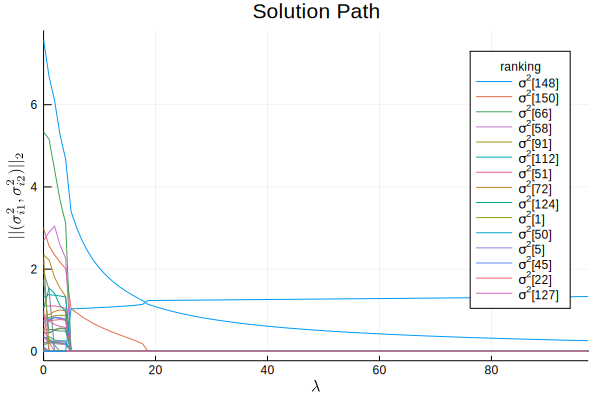

In [9]:
plotsolpath(σ̂2path, σ̂2intpath, λpath; nranks=15)

If we do not want legend, simply do `legend=false` or `nranks=0`. From the plot, one line does not decrease to 0 as $\lambda$ increases. The line represents $\sigma_0^2$, which is not part of the selection and expected to be greater than 0. 

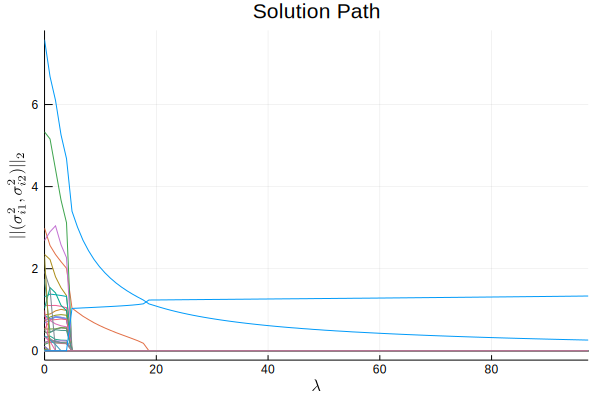

In [10]:
plotsolpath(σ̂2path, σ̂2intpath, λpath; legend=false)

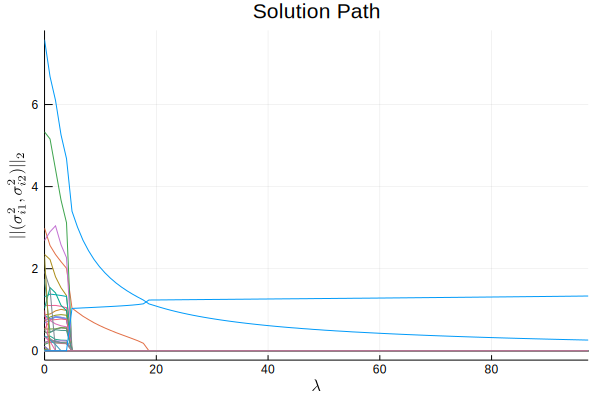

In [11]:
plotsolpath(σ̂2path, σ̂2intpath, λpath; nranks=0)